# DRL Exercise 1: Q-Learning

Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

In this assignment, we will experiment with OpenAI Gymnasium, a testbed for reinforcement learning algorithms containing environments with different difficulty levels.

First, we will implement a tabular Q-learning model on the simple environment of FrozenLake.  

Next, we will move to a larger scale environment and use a neural network function approximation of the Q-value, the basic DQN algorithm.

Lastly, we will try to improve DQN with one of the state-of-the-art algorithms from recent years.

In [ ]:
!pip install gymnasium
!pip install torch torchvision

## Section 1: Tabular Q-Learning

**Model-free** methods in reinforcement learning are constructed for environments whose dynamics (i.e. the physics of the world) are unknown or too complicated to simply be given to the agent.

A few model-free methods have been developed to overcome this issue such as SARSA and Q-learning. Both algorithms' goal is to find the optimal Q-value for each state-action pair that the optimal policy will be derived from, where the Q-value is the expected discounted sum of rewards for an action taken in a specific state. Both algorithms manage a look-up table for the current Q-value approximation of each state-action pair. In each step, the approximation for the current state and action is updated with respect to the target.


**Why can't methods such as value iteration be implemented in model-free environments?**

Methods like value iteration cannot be used in model-free environments because the value iteration method requires knowledge of the environment’s dynamics, which doesn’t exist in a model-free environment. In the value iteration method, we need to know the probability of the next state and reward given the current state and action, *p(s',r|s,a)* for the transition between the two states, However, in model-free environments, the agent does not have access to the transition dynamics between states, and rewards and next states are only revealed through direct interaction with the environment. This is the main problem preventing value iteration from being implemented in a model-free environment.

**How do model-free methods resolve this problem?**

Instead of relying on a model of the environment, model-free methods learn directly from experience and subsequently approximate the value function or policy through these interactions with the environment. The agent takes action *a* in state *s* and then observes the resulting next state and reward. It then updates the value function or Q-function using these observations.

**What is the main difference between the SARSA and Q-learning algorithms?**

While both Q-Learning and SARSA are temporal difference learning methods, the main difference between them is that SARSA is an on-policy method and Q-Learning is an off-policy method. Another main difference between the two is in how they update the Q-function after each action. SARSA follows an ϵ -greedy policy to select the next action, and in turn the next state and reward are subsequently observed following this action. In Q-learning, the action with the maximum Q’ is chosen for the next step to update the Q-function. The significance of this is that Q-learning focuses on learning the optimal policy based on maximizing the Q-function even at the risk of failing (e.g. falling off the cliff), while SARSA will find the safer, possibly less optimal path that avoids risky areas during exploration.

There are several ways for sampling the next action in each iteration of the algorithm. One of the most common is **decaying ϵ-greedy**, where the value of ϵ decreases over time.

**Why is this method better than acting greedily (i.e. choosing $argmax_a Q(s',a)$?**

The greedy approach tries to maximize Q and find the optimal policy but this can limit exploration. The ϵ-greedy approach tries to balance exploration with exploitation. A decaying ϵ-greedy approach will reduce the amount of exploration over time and prioritize exploitation. This allows the algorithm to gather more information about the environment at first, and then focus on acting optimally. This is better than a purely greedy approach since at first, the Q-function estimates are not very accurate because of the limited experience of the agent. Then, when the estimates become more accurate, the agent can focus on exploitation. This can also help prevent the algorithm from converging too soon to a suboptimal policy.

In this section, we will be implementing the basic Q-learning algorithm on the FrozenLake environment, and sampling will be performed using the decaying ϵ-greedy method.

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline

In [ ]:
def epsilon_greedy_algo(state, epsilon, q_table):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample() # explore with epsilon
    return np.argmax(q_table[state])  # exploit

In [ ]:
def train_hyperparameters_q_learning(env, alpha, gamma, epsilon_decay, num_episodes=5000, max_steps=100):

    # Q-table initialization
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_table = np.zeros((num_states, num_actions))

    epsilon = 1.0
    epsilon_min = 0.01
    rewards = []
    steps_to_goal = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            action = epsilon_greedy_algo(state, epsilon, q_table)
            next_state, reward, done, _, _ = env.step(action)

            if done:
                target = reward
            else:
                target = reward + gamma * np.max(q_table[next_state])

            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * target
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        rewards.append(total_reward)
        steps_to_goal.append(steps if total_reward > 0 else max_steps)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    avg_reward = np.mean(rewards[-100:])
    avg_steps = np.mean(steps_to_goal[-100:])

    return avg_reward, avg_steps, q_table

In [ ]:
# Initialize the environment and hyperparameters
env = gym.make("FrozenLake-v1", is_slippery=True)
alpha_values = [0.1, 0.5, 0.8]
gamma_values = [0.8, 0.9, 0.95]
epsilon_decay_values = [0.99, 0.995, 0.999]

results = []
for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon_decay in epsilon_decay_values:
            print(f"Training with alpha={alpha}, gamma={gamma}, epsilon_decay={epsilon_decay}...")
            avg_reward, avg_steps, q_table = train_hyperparameters_q_learning(
                env, alpha, gamma, epsilon_decay, num_episodes=5000, max_steps=100
            )
            results.append({
                "alpha": alpha,
                "gamma": gamma,
                "epsilon_decay": epsilon_decay,
                "avg_reward": avg_reward,
                "avg_steps": avg_steps
            })

best_result = max(results, key=lambda x: x["avg_reward"])

print("\nBest Hyperparameters:")
print(f"Alpha: {best_result['alpha']}")
print(f"Gamma: {best_result['gamma']}")
print(f"Epsilon Decay: {best_result['epsilon_decay']}")
print(f"Average Reward: {best_result['avg_reward']}")
print(f"Average Steps to Goal: {best_result['avg_steps']}")

Training with alpha=0.1, gamma=0.8, epsilon_decay=0.99...
Training with alpha=0.1, gamma=0.8, epsilon_decay=0.995...
Training with alpha=0.1, gamma=0.8, epsilon_decay=0.999...
Training with alpha=0.1, gamma=0.9, epsilon_decay=0.99...
Training with alpha=0.1, gamma=0.9, epsilon_decay=0.995...
Training with alpha=0.1, gamma=0.9, epsilon_decay=0.999...
Training with alpha=0.1, gamma=0.95, epsilon_decay=0.99...
Training with alpha=0.1, gamma=0.95, epsilon_decay=0.995...
Training with alpha=0.1, gamma=0.95, epsilon_decay=0.999...
Training with alpha=0.5, gamma=0.8, epsilon_decay=0.99...
Training with alpha=0.5, gamma=0.8, epsilon_decay=0.995...
Training with alpha=0.5, gamma=0.8, epsilon_decay=0.999...
Training with alpha=0.5, gamma=0.9, epsilon_decay=0.99...
Training with alpha=0.5, gamma=0.9, epsilon_decay=0.995...
Training with alpha=0.5, gamma=0.9, epsilon_decay=0.999...
Training with alpha=0.5, gamma=0.95, epsilon_decay=0.99...
Training with alpha=0.5, gamma=0.95, epsilon_decay=0.995..

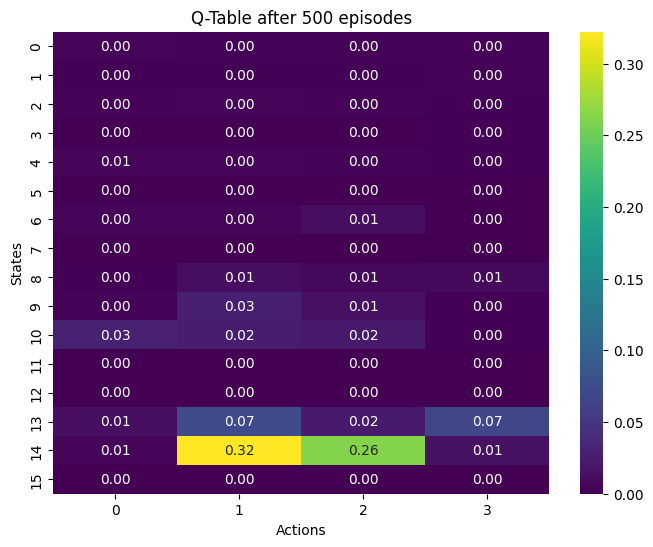

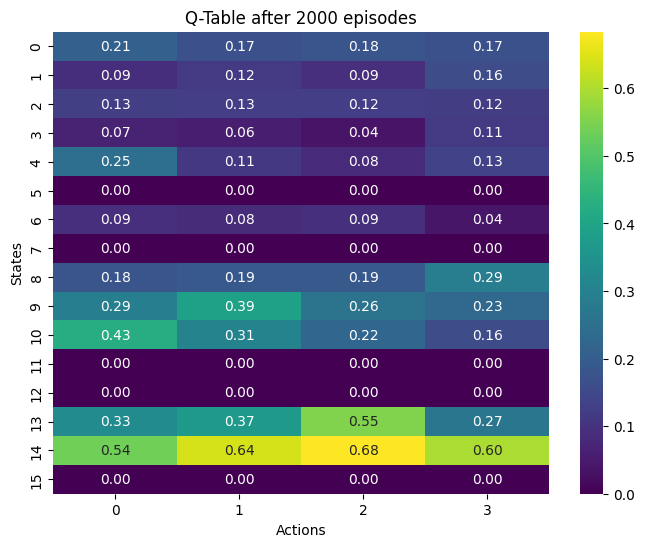

In [ ]:
def train_q_learning(env, alpha, gamma, epsilon_decay, num_episodes=5000, max_steps=100):

    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_table = np.zeros((num_states, num_actions))

    epsilon = 1.0
    epsilon_min = 0.01
    rewards = []
    steps_to_goal = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            action = epsilon_greedy_algo(state, epsilon, q_table)
            next_state, reward, done, _, _ = env.step(action)

            if done:
                target = reward
            else:
                target = reward + gamma * np.max(q_table[next_state])

            q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * target
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        rewards.append(total_reward)
        steps_to_goal.append(steps if total_reward > 0 else max_steps)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode + 1 == 500 or episode + 1 == 2000:
            plt.figure(figsize=(8, 6))
            sns.heatmap(q_table, annot=True, fmt=".2f", cmap="viridis")
            plt.title(f"Q-Table after {episode + 1} episodes")
            plt.xlabel("Actions")
            plt.ylabel("States")
            plt.show()
            plt.close()

    return rewards, steps_to_goal, q_table

rewards, steps_to_goal, best_q_table = train_q_learning(
    env, best_result['alpha'], best_result['gamma'], best_result['epsilon_decay'], num_episodes=5000, max_steps=100)

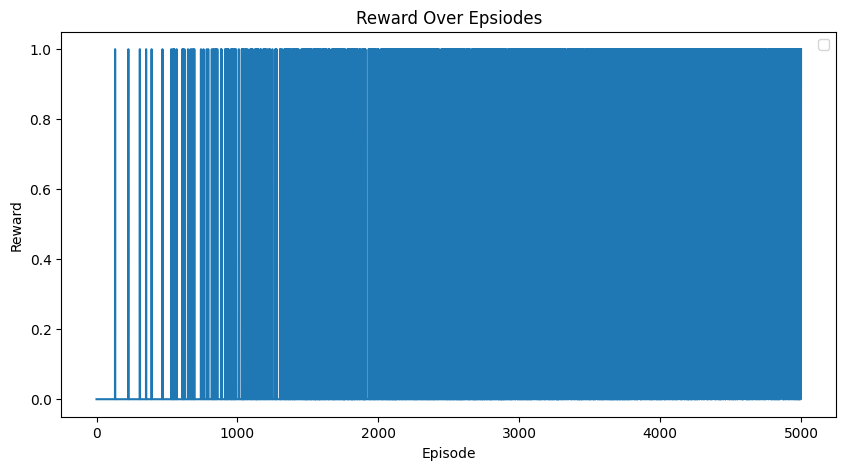

In [ ]:
# Plot: reward per episode

plt.figure(figsize=(10, 5))
plt.plot(range(0, 5000), rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Over Epsiodes")
plt.legend()
plt.show()

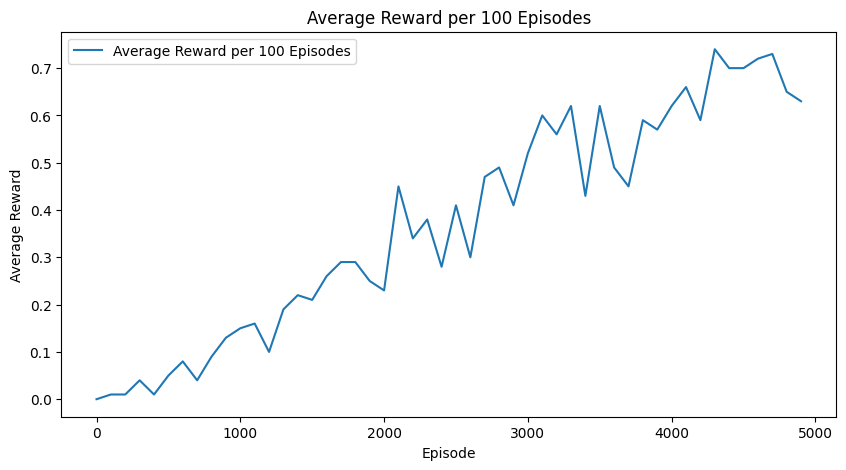

In [ ]:
# Plot: average reward per 100 episodes

average_reward = [
    np.mean(rewards[i : i + 100]) for i in range(0, len(rewards), 100)
]
plt.figure(figsize=(10, 5))
plt.plot(range(0, 5000, 100), average_reward, label="Average Reward per 100 Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Average Reward per 100 Episodes")
plt.legend()
plt.show()

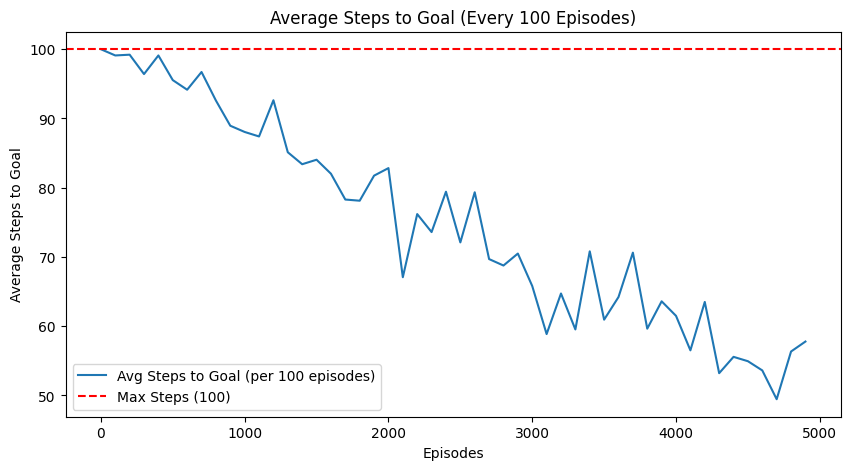

In [ ]:
# Plot: Average number of steps to goal per 100 episodes

average_steps = [
    np.mean(steps_to_goal[i : i + 100]) for i in range(0, len(steps_to_goal), 100)
]
plt.figure(figsize=(10, 5))
plt.plot(range(0, 5000, 100), average_steps, label="Avg Steps to Goal (per 100 episodes)")
plt.axhline(y=100, color="r", linestyle="--", label="Max Steps (100)")
plt.xlabel("Episodes")
plt.ylabel("Average Steps to Goal")
plt.title("Average Steps to Goal (Every 100 Episodes)")
plt.legend()
plt.show()


Training completed!


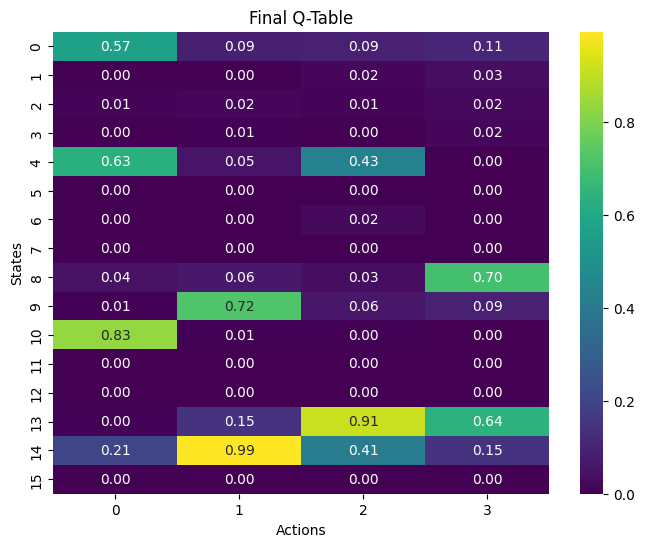

In [ ]:
print("\nTraining completed!")
plt.figure(figsize=(8, 6))
sns.heatmap(q_table, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Final Q-Table")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()

## Section 2: Deep Q-Learning

The main problem with Q-learning is scalability. Most of the more interesting environments and problems have a high number of states or have a continuous state distribution that is then discretized such that it is not feasible to represent them all in a look-up table.

The solution for this problem is a Q-function approximation. Instead of saving the current state-action pair value in a table, we use a function that can approximate the value. This function takes the state-action pair as input and outputs the approximate Q-value.

In deep Q-learning, we use a neural network as the function approximator. The loss function used for the network's gradient descent is MSE between the target and the Q-value approximation. In DQN, instead of updating the weights of the network in each step, we can use two additional methods for stabilizing the network: **experience replay** and **an older set of weights**.

**Experience Replay**

Experience replay is a method designed to address the issues of catastrophic forgetting (where the model's older experiences are overwritten by the newer ones, and so the model "forgets") and correlation between states. We use a “replay buffer” to record and re-introduce previously viewed trajectories to the model.

**Why do we sample these experiences in random order?**

We sample experiences in random order for experience replay in order to help stabilize and improve the learning process by providing a large variety of experiences for the agent to train on. Because we train sequentially, experiences can be temporally correlated, but sampling in random order helps to remove this correlation. In addition, the random sampling of previous experiences helps the agent to “remember” previous experiences, helping it to generalize better and not overfit to any situation such as the most recent experiences.

**Use an older set of weights to compute targets**

We can separate the network into two different networks - one for computing the targets using an older set of parameters, and one for predicting the Q-value that is being updated every iteration (or minibatch). Instead of updating the "old" parameters of the target network every step, we do it once every *C* steps.

**How does this improve the model?**

Using an older set of weights to compute targets improves the model by addressing the moving target problem, where the reward goal (target) always stays ahead of us because we are using the same parameters for both the estimation and the target. This allows the Q-values to converge more smoothly and faster convergence to the optimal Q-function.

In this section we will be implementing an agent using the basic DQN algorithm on the CartPole environment. We try two different structures for the neural network: one with 3 layers and one with 5 layers. We use the same network for both the q-value network and the target network but with different weights. When building the neural network, we decided on a simple DNN construction where each hidden layer has 64 neurons and a ReLU activation function is applied after every layer.

We implement experience replay and use a decaying ϵ-greedy sampling method. Our loss function is MSE loss and we use the Adam optimizer.



We ran **hyperparameter optimization** in order to determine the best parameters for each network.

The hyperparameter that affected the performance the most was the learning rate. We calculated the average rewards for each of the hyperparameter values that we tested and looked for the largest difference between values of the same hyperparameter. The average reward for the learning rate of 0.001 was 145.76, and the average reward for the learning rate of 0.005 was 152.72. The next most important hyperparameter was gamma with a similar distance of 6.09 between values.



In [ ]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(DQNNetwork, self).__init__()
        layers = [nn.Linear(input_dim, 64), nn.ReLU()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(64, 64))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(64, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, experience):
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)

In [ ]:
def sample_action(network, state, epsilon, action_space):
    if np.random.uniform(0, 1) < epsilon: #explore
        return action_space.sample() # sample the action space
    else: #exploit
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0) # create tensor from state
        with torch.no_grad():
            q_values = network(state_tensor) # pass state through the NN to get q-value approximations
        return torch.argmax(q_values).item() # take the maximum q-value

In [ ]:
def train_dqn_experience_replay(target_network, q_network, criterion, optimizer, experience_replay, batch_size, gamma):
    states, actions, rewards, next_states, dones = experience_replay.sample_batch(batch_size)
    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        targets = rewards + gamma * next_q_values * (1 - dones)

    # gradient descent
    loss = criterion(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# average reward over 100 episodes tracking
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards):
    target_average = 475.0

    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        episodes_to_target = episode + 1
        print(f"Agent reached an average reward of {target_average} over 100 episodes at episode {episodes_to_target}")

    return rolling_avg

In [ ]:
def train_agent(env, num_hidden_layers, max_steps=500, max_episodes=20000, batch_size=32, gamma=0.99, epsilon_decay=0.995, min_epsilon=0.1,
                target_update_freq=10, replay_buffer_size=2000, learning_rate=0.001):
    state_size = env.observation_space.shape[0] #vector of size 4 with continuous values: (position, velocity, angle, angular velocity)
    num_actions = env.action_space.n

    q_network = DQNNetwork(state_size, num_actions, num_hidden_layers)
    target_network = DQNNetwork(state_size, num_actions, num_hidden_layers)
    target_network.load_state_dict(q_network.state_dict()) #sync both networks
    target_network.eval()

    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    experience_replay = ReplayBuffer(max_size=replay_buffer_size)
    epsilon = 1.0
    rewards_per_episode = []
    rolling_avg_rewards = []
    losses = []

    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = sample_action(q_network, state, epsilon, env.action_space)
            next_state, reward, done, _ = env.step(action)
            experience_replay.store((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if experience_replay.size() >= batch_size:
                loss = train_dqn_experience_replay(target_network, q_network, criterion, optimizer, experience_replay, batch_size, gamma)
                losses.append(loss)

            if done:
                break

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        # update target network periodically
        if episode % target_update_freq == 0:
            target_network.load_state_dict(q_network.state_dict())

        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards)
        print(f"Episode {episode+1}/{max_episodes}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}, Epsilon: {epsilon:.2f}")

        if rolling_avg_reward >= 475.0:
            break

    return q_network, rewards_per_episode, losses


In [ ]:
def test_agent(env, model, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            env.render()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            with torch.no_grad():
                action = torch.argmax(model(state_tensor)).item()

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Test Episode {episode+1}: Total Reward: {total_reward}")

In [ ]:
env = gym.make("CartPole-v1", render_mode='human')
best_params = (0.0005, 0.99, 64, 0.99, 1000)

# Best parameters from optimization: (0.0001, 0.99, 32, 0.99, 5000) 3 layers
# (0.0005, 0.95, 32, 0.99, 1000) 5 layers

lr, gamma, batch_size, epsilon_decay, replay_capacity = best_params
q_network, rewards, losses = train_agent(env, num_hidden_layers=5, batch_size=batch_size, gamma=gamma,
                                             epsilon_decay=epsilon_decay, replay_buffer_size=replay_capacity, learning_rate=lr)

# Test the trained agent
print("\nTesting trained agent...")
test_agent(env, q_network)

In [ ]:
# Plot: loss in each training step

plt.figure(figsize=(12, 6))
plt.plot(losses, label=f"5 Hidden Layers")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Loss per Training Step")
plt.legend()
plt.show()

In [ ]:
# Plot: total reward of each episode in training

plt.figure(figsize=(12, 6))
plt.plot(rewards, label=f"5 Hidden Layers")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Progression")
plt.legend()
plt.show()

**3 Layers**

When we used the neural network with 3 layers, it took until episode 7575 to reach an average reward over 100 episodes of at least 475.

The optimal hyperparameters for this network were:

* Learning rate = 0.001
* Gamma = 0.99
* Batch size = 32
* Epsilon decay rate = 0.99
* Replay capacity = 5000




**Plot of Training Loss**

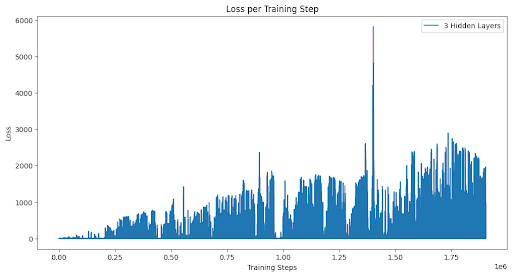

**Plot of Total Rewards**

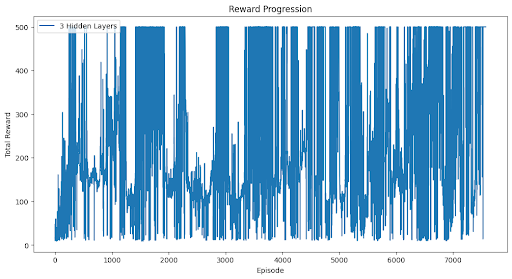

**5 Layers**

When we used the neural network with 5 layers, it took until episode 9789 to reach an average reward over 100 episodes of at least 475.

The optimal hyperparameters for this network were:

* Learning rate = 0.005
* Gamma = 0.95
* Batch size = 32
* Epsilon decay rate = 0.99
* Replay capacity = 1000


**Plot of Training Loss**

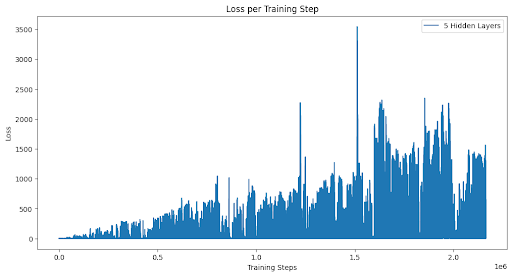

**Plot of Total Rewards**

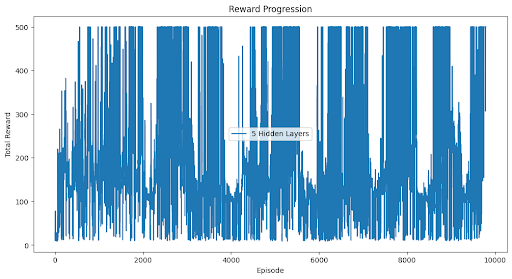

### Hyperparameter Optimization

We ran hyperparameter optimization on a smaller number of episodes (500) with a smaller number of possible steps (200) in order to cut down on the runtime. We also ran the optimization while differentiating between our network with 3 hidden layers and our network with 5 hidden layers, meaning that we have different optimal parameters for each network.

In [ ]:
# hyperparameter optimization

learning_rates = [0.001, 0.0005]
gamma_values = [0.99, 0.95]
batch_sizes = [32, 64]
epsilon_decays = [0.995, 0.99]
replay_capacities = [1000, 5000]
hidden_layers = [3, 5]

# shorter runs for hyperparameter tuning
short_episodes = 500
short_steps = 200

results = []

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n
best_params = None
best_avg_reward = -float("inf")

for lr, gamma, batch_size, epsilon_decay, replay_capacity, hidden_layers in product(
        learning_rates, gamma_values, batch_sizes, epsilon_decays, replay_capacities, hidden_layers):

    _, rewards, losses = train_agent(env, num_hidden_layers=hidden_layers, max_steps=short_steps, max_episodes=short_episodes, batch_size=batch_size,
                                     gamma=gamma, epsilon_decay=epsilon_decay, replay_buffer_size=replay_capacity, learning_rate=lr)
    avg_reward = np.mean(rewards[-100:])

    print(f"Params: lr={lr}, gamma={gamma}, batch_size={batch_size}, epsilon_decay={epsilon_decay}, replay_capacity={replay_capacity}, hidden_layers={hidden_layers}")
    print(f"Average reward: {avg_reward}")

    results.append(((lr, gamma, batch_size, epsilon_decay, replay_capacity, hidden_layers), avg_reward))

    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        best_params = (lr, gamma, batch_size, epsilon_decay, replay_capacity, hidden_layers)

print("Best parameters:", best_params)
print("Best average reward on short run:", best_avg_reward)

params_labels = [f"LR={p[0]}, Gamma={p[1]}, Batch Size={p[2]}, Epsilon Decay={p[3]}, Replay Capacity={p[4]}, Hidden Layers={p[5]}"
                 for p, _ in results]
avg_rewards = [r for _, r in results]

plt.figure(figsize=(12, 6))
plt.barh(params_labels, avg_rewards, color="skyblue")
plt.xlabel("Average Reward")
plt.ylabel("Parameter Combination")
plt.title("Hyperparameter Tuning Results")
plt.tight_layout()
plt.show()


The hyperparameter combinations that produced the highest rewards during the optimization runs can be seen in the following graph:


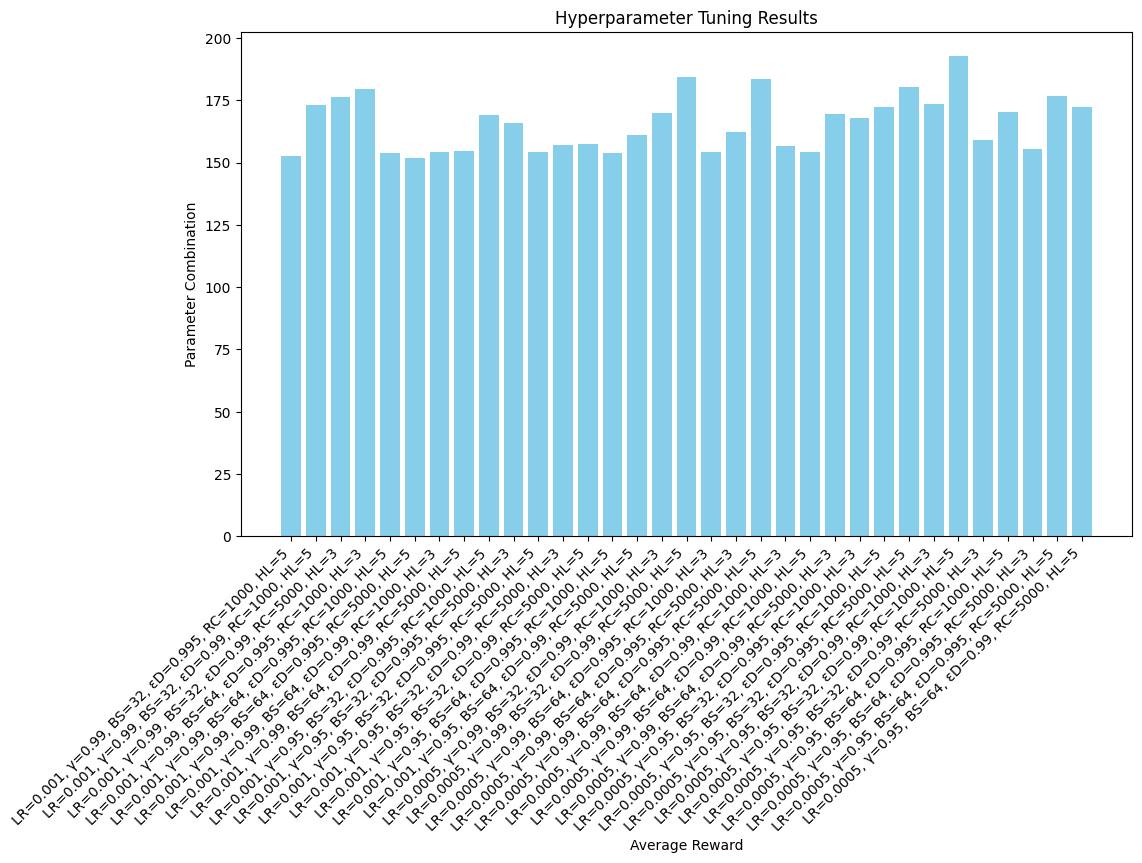

In [ ]:
params_labels = [f"LR={p[0]}, γ={p[1]}, BS={p[2]}, εD={p[3]}, RC={p[4]}, HL={p[5]}"
                 for p, _ in results]
avg_rewards = [r for _, r in results]
threshold = 150

filtered_labels = [label for label, reward in zip(params_labels, avg_rewards) if reward >= threshold]
filtered_rewards = [reward for reward in avg_rewards if reward >= threshold]

plt.figure(figsize=(12, 6))
plt.bar(filtered_labels, filtered_rewards, color="skyblue")
plt.xlabel("Average Reward")
plt.ylabel("Parameter Combination")
plt.title("Hyperparameter Tuning Results")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
results_df = pd.DataFrame(results, columns=["Params", "Average Reward"])

results_df["Learning Rate"] = [p[0] for p in results_df["Params"]]
results_df["Gamma"] = [p[1] for p in results_df["Params"]]
results_df["Batch Size"] = [p[2] for p in results_df["Params"]]
results_df["Epsilon Decay"] = [p[3] for p in results_df["Params"]]
results_df["Replay Capacity"] = [p[4] for p in results_df["Params"]]
results_df["Hidden Layers"] = [p[5] for p in results_df["Params"]]

for hp in ["Learning Rate", "Gamma", "Batch Size", "Epsilon Decay", "Replay Capacity", "Hidden Layers"]:
    grouped = results_df.groupby(hp)["Average Reward"].mean()
    print(f"Average Reward by {hp}:")
    print(grouped)
    print()


Average Reward by Learning Rate:
Learning Rate
0.0005    152.718750
0.0010    145.755937
Name: Average Reward, dtype: float64

Average Reward by Gamma:
Gamma
0.95    152.284063
0.99    146.190625
Name: Average Reward, dtype: float64

Average Reward by Batch Size:
Batch Size
32    149.348750
64    149.125937
Name: Average Reward, dtype: float64

Average Reward by Epsilon Decay:
Epsilon Decay
0.990    148.879687
0.995    149.595000
Name: Average Reward, dtype: float64

Average Reward by Replay Capacity:
Replay Capacity
1000    147.879063
5000    150.595625
Name: Average Reward, dtype: float64

Average Reward by Hidden Layers:
Hidden Layers
3    148.684063
5    149.790625
Name: Average Reward, dtype: float64



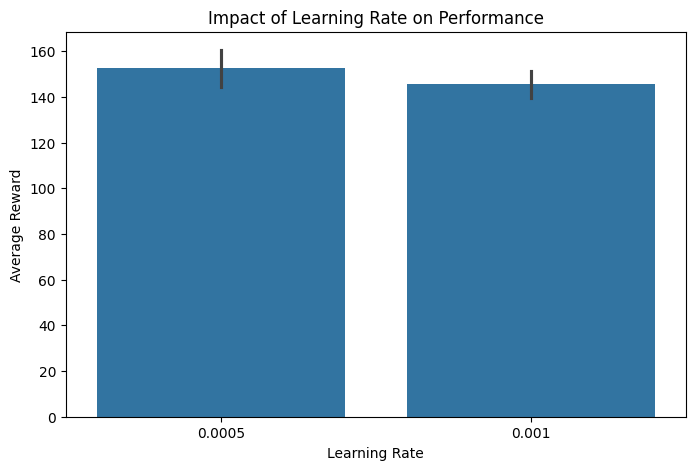

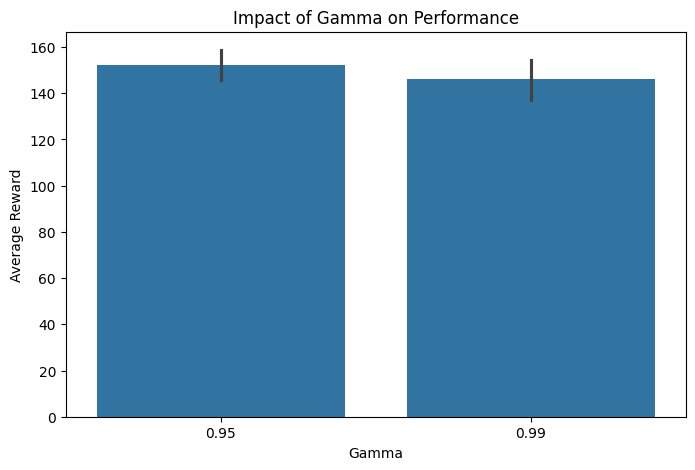

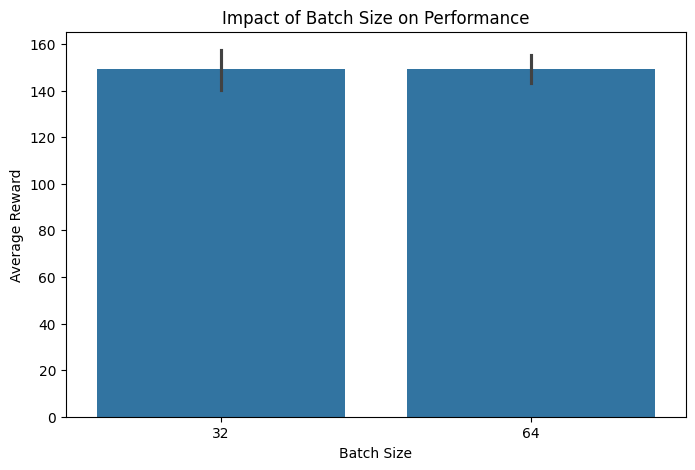

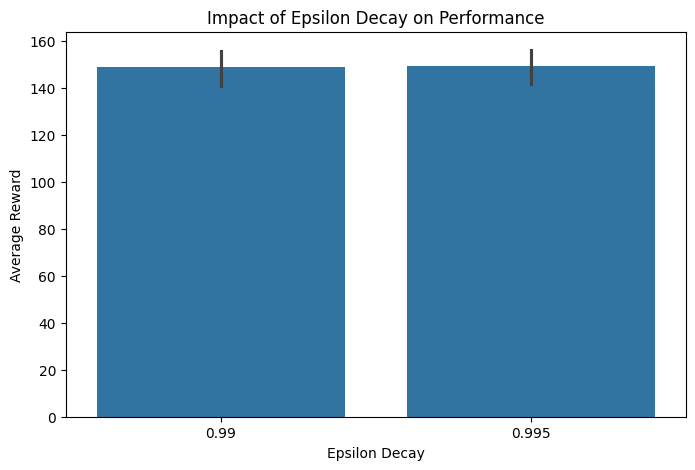

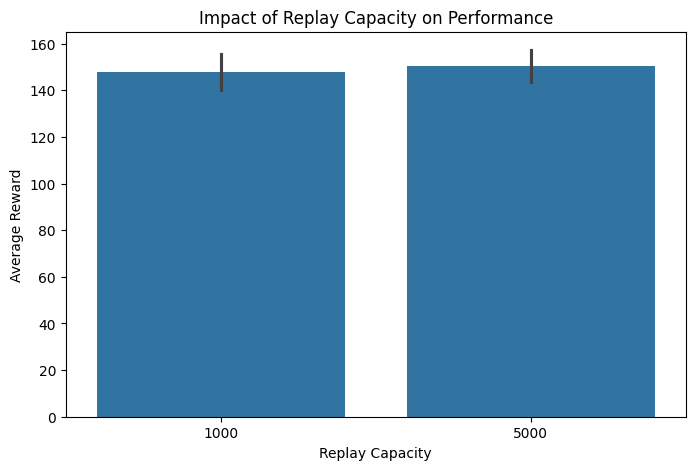

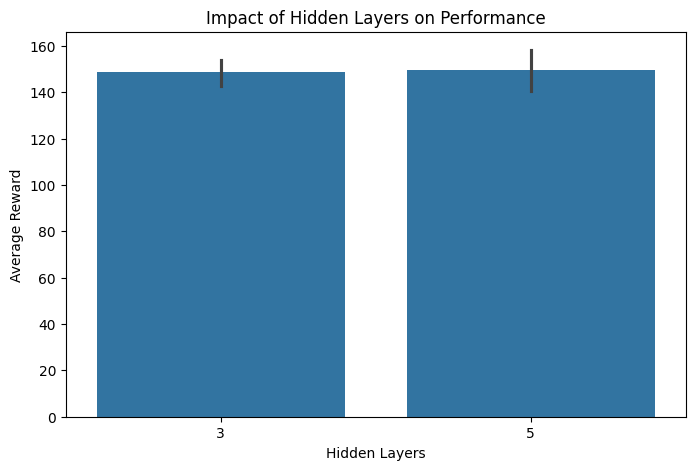

In [ ]:
import seaborn as sns

# Plot the average reward for each hyperparameter
for hp in ["Learning Rate", "Gamma", "Batch Size", "Epsilon Decay", "Replay Capacity", "Hidden Layers"]:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=hp, y="Average Reward", data=results_df)
    plt.title(f"Impact of {hp} on Performance")
    plt.xlabel(hp)
    plt.ylabel("Average Reward")
    plt.show()


## Section 3: Improved DQN

Since the DQN algorithm was originally published, a few improvements have been suggested in different papers such as **prioritized experience replay** and **DDQN**.

The improvement that we chose to implement is **stochastic prioritized experience replay**, where the experiences that are chosen to replay are chosen based on their TD error, and those experiences with higher TD error are prioritized. Stochastic prioritized experience replay simply means that we are sampling the experiences according to a probability related to the TD error. The purpose of this is to help the model train better, faster because we are making it redo the trajectories that it has a higher error on, meaning there is more to learn there. We also added in **importance sampling** to help correct the bias that was possibly introduced from the non-uniform sampling.

We used the same neural network as in section 2 but focused on the version with 5 hidden layers because we saw during the hyperparameter optimization process in section 2 that the average reward for the network with 5 hidden layers was higher than the network with 3 hidden layers.

The optimal hyperparameters for this network were:

* Learning rate = 0.005
* Gamma = 0.99
* Batch size = 32
* Epsilon decay rate = 0.995
* Replay capacity = 1000
* Alpha = 0.6
* Beta = 0.5




In [ ]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(DQNNetwork, self).__init__()
        layers = [nn.Linear(input_dim, 64), nn.ReLU()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(64, 64))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(64, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class PrioritizedExperienceReplay:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_increment=1e-4):
        self.capacity = capacity
        self.memory = []
        self.priorities = []  # list of p_i
        self.alpha = alpha    # temperature
        self.beta = beta_start
        self.beta_increment = beta_increment
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.memory[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.capacity

    def sample_batch(self, batch_size):
        probabilities = np.array(self.priorities) ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[idx] for idx in indices]

        self.beta = min(1.0, self.beta + self.beta_increment)  # reduce bias correction as training increases
        weights = (len(self.memory) * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()

        batch = list(zip(*samples))
        return (
            torch.tensor(np.array(batch[0]), dtype=torch.float32),
            torch.tensor(batch[1], dtype=torch.int64),
            torch.tensor(batch[2], dtype=torch.float32),
            torch.tensor(np.array(batch[3]), dtype=torch.float32),
            torch.tensor(batch[4], dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices,
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority


In [ ]:
def sample_action(network, state, epsilon, action_space):
    if np.random.uniform(0, 1) < epsilon: #explore
        return action_space.sample() # sample the action space
    else: #exploit
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0) # create tensor from state
        with torch.no_grad():
            q_values = network(state_tensor) # pass state through the NN to get q-value approximations
        return torch.argmax(q_values).item() # take the maximum q-value

In [ ]:
def train_dqn_prioritized_experience_replay(target_network, q_network, criterion, optimizer, experience_replay, batch_size, gamma):
    states, actions, rewards, next_states, dones, weights, indices = experience_replay.sample_batch(batch_size)

    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        targets = rewards + gamma * next_q_values * (1 - dones)

    td_errors = (q_values - targets).abs().detach().numpy()
    loss = (weights * criterion(q_values, targets)).mean()   # importance sampling

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    experience_replay.update_priorities(indices, td_errors)

    return loss.item()


In [ ]:
def train_agent_prioritized(env, num_hidden_layers, alpha, beta_start, max_steps=500, max_episodes=20000, batch_size=32, gamma=0.99,
                            epsilon_decay=0.995, min_epsilon=0.1, target_update_freq=10, replay_buffer_size=10000, learning_rate=0.001):
    state_size = env.observation_space.shape[0]
    num_actions = env.action_space.n


    q_network = DQNNetwork(state_size, num_actions, hidden_layers=2)
    target_network = DQNNetwork(state_size, num_actions, hidden_layers=2)
    target_network.load_state_dict(q_network.state_dict())
    target_network.eval()

    optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    experience_replay = PrioritizedExperienceReplay(capacity=replay_buffer_size, alpha=alpha, beta_start=beta_start)

    epsilon = 1.0
    rewards_per_episode = []
    losses = []
    rolling_avg_rewards = []

    for episode in range(max_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0

        for step in range(max_steps):
            action = sample_action(q_network, state, epsilon, env.action_space)
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            total_reward += reward

            experience_replay.push(state, action, reward, next_state, done)
            state = next_state

            if len(experience_replay.memory) >= batch_size:
                loss = train_dqn_prioritized_experience_replay(target_network, q_network, criterion, optimizer, experience_replay, batch_size, gamma)
                losses.append(loss)

            if done:
                break

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        if episode % target_update_freq == 0:
            target_network.load_state_dict(q_network.state_dict())

        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards)
        print(f"Episode {episode+1}/{max_episodes}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}, Epsilon: {epsilon:.2f}")


    return q_network, rewards_per_episode, losses


In [ ]:
env = gym.make("CartPole-v1", render_mode='human')
best_params = (0.0005, 0.95, 64, 0.995, 10000, 0.6, 0.5)
num_hidden_layers = 5

# Best parameters from optimization (5 layers):
# LR=0.0005, Gamma=0.99, Batch Size=32, Epsilon Decay=0.995, Replay Capacity=1000, Alpha=0.6, Beta=0.5, Avg Reward=179.81

lr, gamma, batch_size, epsilon_decay, replay_capacity, alpha, beta = best_params
q_network, rewards, losses = train_agent_prioritized(env, num_hidden_layers, alpha, beta, batch_size=batch_size, gamma=gamma,
                                             epsilon_decay=epsilon_decay, replay_buffer_size=replay_capacity, learning_rate=lr)

# Test the trained agent
print("\nTesting trained agent...")
test_agent(env, q_network)

We actually ran the improved DQN multiple times where it never reached a rolling average of 475, instead fluctuating between the 100s to 300s, and spending most of its time in the 200s. The run where it did reach a rolling average of 475, it took until episode 15,233. The plots below of the training loss and the total rewards are of the run up until episode 2000 for clarity’s sake (as opposed to plotting these values for all 15,000 episodes).

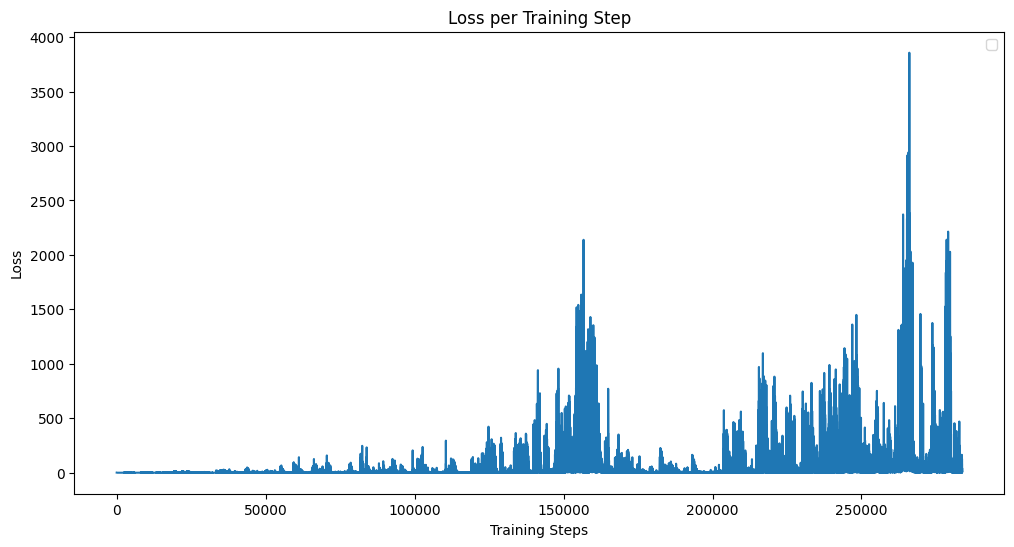

In [ ]:
# Plot: loss in each training step

plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Loss per Training Step")
plt.legend()
plt.show()

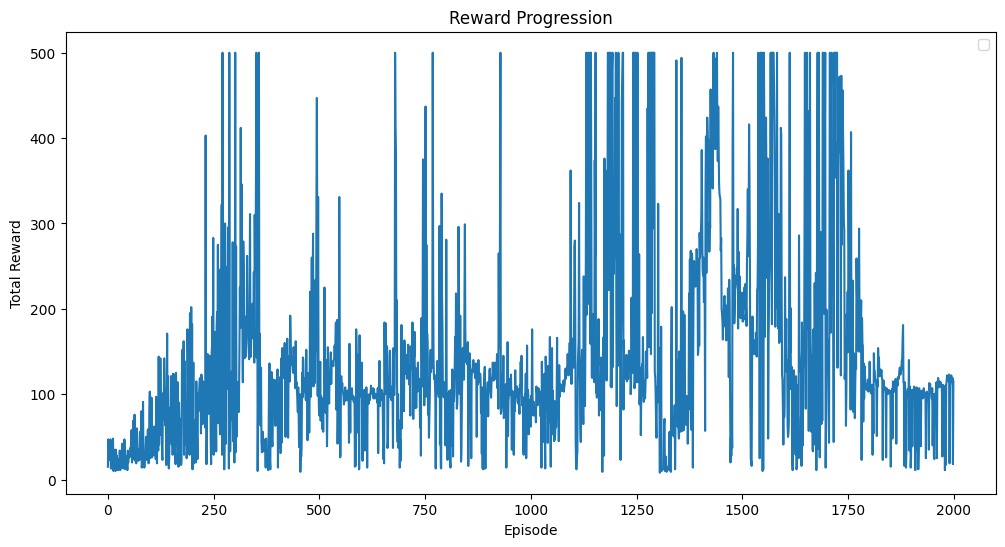

In [ ]:
# Plot: total reward of each episode in training

plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Progression")
plt.legend()
plt.show()

### Hyperparameter Optimization

In [ ]:
# hyperparameter optimization

learning_rates = [0.001, 0.0005]
gamma_values = [0.99, 0.95]
batch_sizes = [32, 64]
epsilon_decays = [0.995, 0.99]
replay_capacities = [1000, 5000]
alpha_values = [0.6, 0.7]
beta_values = [0.4, 0.5]

# shorter runs for hyperparameter tuning
short_episodes = 500
short_steps = 200
hidden_layers = 5

results = []

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n
best_params = None
best_avg_reward = -float("inf")

for lr, gamma, batch_size, epsilon_decay, replay_capacity, alpha, beta in product(
        learning_rates, gamma_values, batch_sizes, epsilon_decays, replay_capacities, alpha_values, beta_values):

    _, rewards, losses = train_agent_prioritized(env, hidden_layers, alpha, beta, max_steps=short_steps, max_episodes=short_episodes, batch_size=batch_size,
                                     gamma=gamma, epsilon_decay=epsilon_decay, replay_buffer_size=replay_capacity, learning_rate=lr)
    avg_reward = np.mean(rewards[-100:])

    results.append(((lr, gamma, batch_size, epsilon_decay, replay_capacity, alpha, beta) ,avg_reward))
    print(f"Config: LR={lr}, Gamma={gamma}, Batch Size={batch_size}, Epsilon Decay={epsilon_decay}, "
          f"Replay Capacity={replay_capacity}, Alpha={alpha}, Beta={beta}, "
          f"Avg Reward={avg_reward}")

    if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        best_params = (lr, gamma, batch_size, epsilon_decay, replay_capacity)

print("Best parameters:", best_params)
print("Best average reward on short run:", best_avg_reward)


## Discussion

We ran the models in section 2 and section 3 multiple times each and noticed a few prominent differences. For both section 2 and 3, we tracked the rolling averages over the last 100 episodes for all the runs, noting the fluctuations. The rolling average was not monotonically increasing for any of the models but we noted that the fluctuations in the rolling average in the section 2 models was more extreme, often rising to the 300s or 400s and then plunging back down to the 100s or below. In the runs for the improved DQN model in section 3, we noticed that while there were fluctuations in the rolling average, they were more gradual. We also noticed that the section 2 model reached a rolling average in the 400s within the first 2000 or so episodes, even if it did not reach an average of 475 until much later, however the improved DQN model fluctuated in the 100-300s range for the majority of the runs, not even reaching a rolling average of 475 in most of them.  From the reward graph we can see that, as mentioned before, the swings in value are much less extreme in the improved DQN model as opposed to the original one.

We believe this is because in prioritized experience replay, the experiences with larger errors are the ones with the higher priority to be replayed by the model in order to learn. This in turn causes lower rewards from the model’s runs because it is not replaying experiences in which it received high rewards, rather exactly the opposite, and thus we are waiting for the general ability of the model playing the game to improve instead of waiting for the model to reach a peak at some point.

We believe that there is definitely room for improvement with this model, mainly further tuning hyperparameters such as the epsilon decay rate in order to allow for greater exploration at first so that the model has a larger variety of experiences to learn from and not possibly a small subset of experiences with high error. Because of time limitations, we did perform the hyperparameter optimization for both sections on a smaller number of possible steps and episodes, which does not necessarily translate to the longer runs in which we were trying to achieve a rolling average of at least 475. Therefore, there is room to improve this implementation with regards to the hyperparameter optimization, and better hyperparameters will most likely drastically change the number of episodes it takes to reach a rolling average of 475. In addition, we only looked at a possible two values for each hyperparameter in both sections, but because there were a number of hyperparameters this led to 64 possible combinations in the section 2 model and 128 possible combinations in the section 3 model. Unfortunately, due to time constraints, we were not able to run the full number of episodes required to reach a rolling average of 475 for each of the combinations, and thus ran a smaller selection of hyperparameters on a smaller number of steps and episodes, which in term might not fit well with longer running times and thus cause the issues we had with the improved DQN model.

In general, we see that adding in the improvement of the prioritized experience replay helped to stabilize the model and helped it learn better in general. However, going forward, we would focus on understanding why the model is not effectively learning from the prioritized experience replay (possible reasons including: imbalanced sampling, imbalanced exploration vs exploitation, target network updating at the wrong frequency, and others) and change it accordingly. This, combined with proper hyperparameter tuning should lead to increased results.
